In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Data loading and verification

In [2]:
df = pd.read_csv("heart-disease-data/heart-disease.csv")

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

### A patient has a heart disease (1) or not (0) => binary classification

In [5]:
df.isna().sum() # check if missing values

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.info() # check if non-numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Correlation Matrix

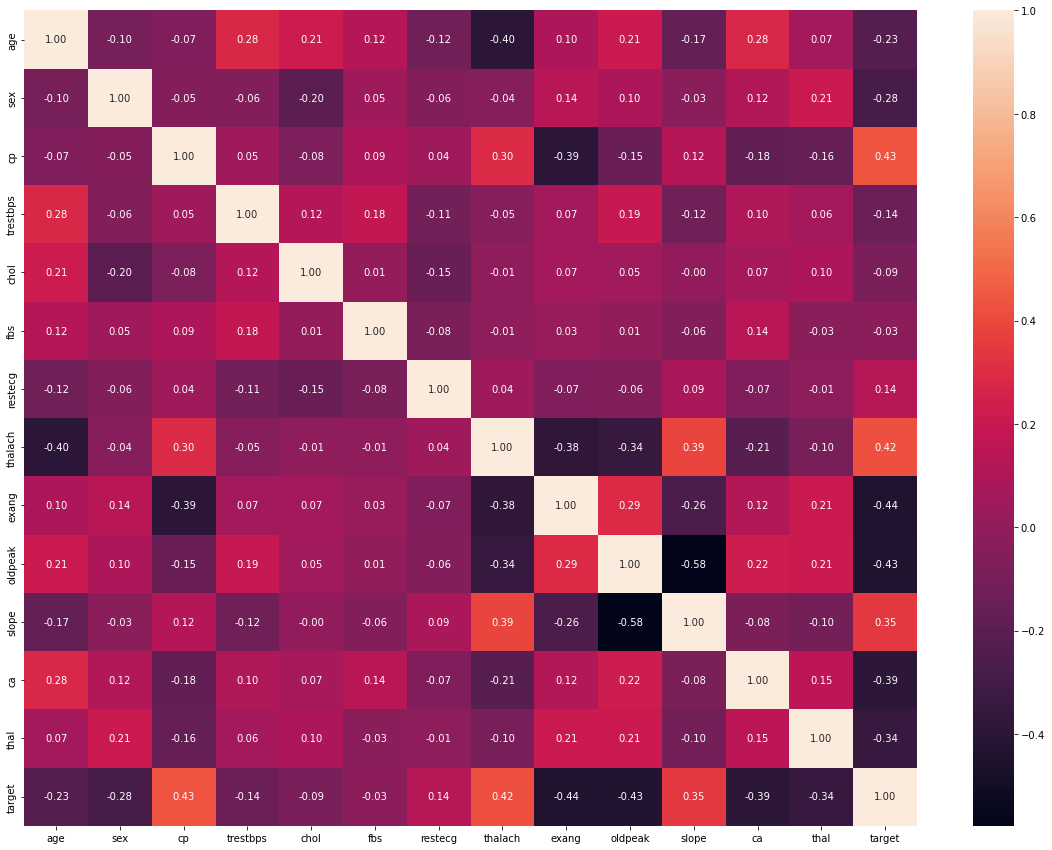

In [7]:
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

# Model fitting

In [8]:
# prepare data for splitting
X = df.drop("target", axis=1)
y = df["target"]

# split data into train set and test set (normal splitting)
np.random.seed(99)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80% train and 20% test

#### Models used:
* Logistic Regression (1000 iterations)
* K-Nearest Neighbors Classifier
* Random Forest Classifier

In [9]:
models = {"Logistic Regression": LogisticRegression(max_iter=1000),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given ML models
    models: dict containing sklearn models
    X_train: training data
    X_test: testing data
    y_train: training labels
    y_test: testing labels
    return: dict containing the score for each given model
    """
    np.random.seed(99)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train) # fitting
        model_scores[name] = model.score(X_test, y_test) # evaluate and store the score
    return model_scores

In [10]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'Logistic Regression': 0.8524590163934426,
 'KNN': 0.6557377049180327,
 'Random Forest': 0.8524590163934426}

# Model tuning

## Hyperparams tuning

#### KNN tuning

Max KNN score on test set: 70.49%


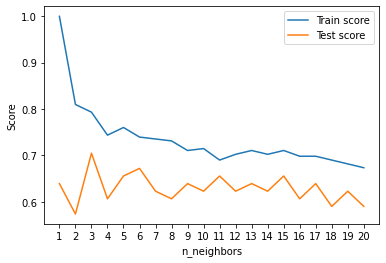

In [11]:
train_scores = []
test_scores = []
neighbors = range(1, 21)
knn = KNeighborsClassifier()
for i in neighbors:
    knn.set_params(n_neighbors=i) # set n_neighbors param
    knn.fit(X_train, y_train) # fitting
    train_scores.append(knn.score(X_train, y_train)) # score and save train set
    test_scores.append(knn.score(X_test, y_test)) # score and save test set

plt.plot(neighbors, train_scores, label="Train score") # plot the results
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.legend()
print(f"Max KNN score on test set: {max(test_scores)*100:.2f}%")

#### Logistic Regression/Random Forest tuning

In [12]:
# create hyperparam grids
lr_grid = {"C": np.logspace(-4, 4, 50),
                "solver": ["newton-cg", "liblinear"]}
rf_grid = {"n_estimators": np.arange(10, 300, 50),
           "max_depth": [None, 3, 5],
           "min_samples_split": np.arange(2, 16, 2),
           "min_samples_leaf": np.arange(2, 16, 2)}
np.random.seed(99)
# tuning using GridSearchCV
rs_lr = GridSearchCV(LogisticRegression(max_iter=10000),
                           param_grid=lr_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=True)
rs_lr.fit(X_train, y_train) # fitting

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'solver': ['newton-cg', 'liblinear']},
             verbose=True)

In [13]:
rs_lr.best_params_

{'C': 0.08685113737513521, 'solver': 'liblinear'}

In [14]:
rs_lr.score(X_test, y_test)

0.8524590163934426

In [15]:
# same for Random Forest
rs_rf = GridSearchCV(RandomForestClassifier(),
                           param_grid=rf_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=True)
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 882 candidates, totalling 4410 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5],
                         'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14]),
                         'n_estimators': array([ 10,  60, 110, 160, 210, 260])},
             verbose=True)

In [16]:
rs_rf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 60}

In [17]:
rs_rf.score(X_test, y_test)

0.8852459016393442

#### The Random Forest Classifier model will be used further on

# Model evaluation

In [18]:
# test data prediction
y_pred = rs_rf.predict(X_test)

### ROC Curve plotting and AUC metric

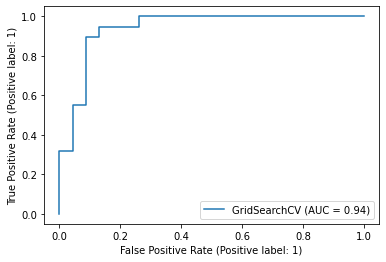

In [19]:
RocCurveDisplay.from_estimator(rs_rf, X_test, y_test);

### Confusion Matrix

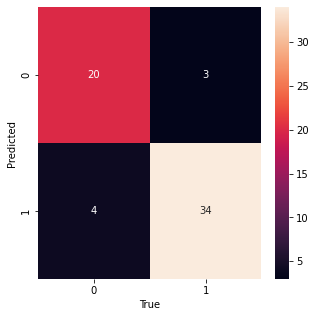

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True)
plt.xlabel("True")
plt.ylabel("Predicted");

### Evaluation metrics via cross-validation

In [21]:
# recreate the classifier
rs_rf.best_params_

{'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 60}

In [22]:
clf = RandomForestClassifier(max_depth=3, 
                             min_samples_leaf=3, 
                             min_samples_split=10, 
                             n_estimators=110)

In [23]:
cv_acc = np.mean(cross_val_score(clf, X, y, cv=5, scoring="accuracy"))
cv_prec = np.mean(cross_val_score(clf, X, y, cv=5, scoring="precision"))
cv_rec = np.mean(cross_val_score(clf, X, y, cv=5, scoring="recall"))
cv_f1 = np.mean(cross_val_score(clf, X, y, cv=5, scoring="f1"))

In [24]:
# pretty print the metrics
print(f"Accuracy: {cv_acc:.2f}")
print(f"Precision: {cv_prec:.2f}")
print(f"Recall: {cv_rec:.2f}")
print(f"F1: {cv_f1:.2f}")

Accuracy: 0.85
Precision: 0.84
Recall: 0.92
F1: 0.86


## Exporting the model

In [25]:
from joblib import dump
dump(clf, "exported-models/heart-disease-rfc-model.joblib")

['exported-models/heart-disease-rfc-model.joblib']